In [1]:
import torch
import pandas as pd
import numpy as np
import os
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianNetwork
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import multiprocessing
import networkx as nx
import matplotlib.pyplot as plt

# 检查CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 加载数据.T
hc_con = pd.read_csv('/Users/martinli/Desktop/SZ/continous_hc.csv', index_col=0)
hc_dis = pd.read_csv('/Users/martinli/Desktop/SZ/discretized_hc.csv', index_col=0)
uc_dis = pd.read_csv('/Users/martinli/Desktop/SZ/discretized_uc.csv', index_col=0)
hc_con = hc_con.T
hc_dis = hc_dis.T
uc_dis = uc_dis.T
print("Data loaded and transposed.")
print("Con Data index (should be sample names):", hc_con.index[:5])
print("Con Data columns (should be gene names):", hc_con.columns[:5])
print("Dis Data index (should be sample names):", hc_dis.index[:5])
print("Dis Data columns (should be gene names):", hc_dis.columns[:5])

index_map = pd.read_csv('/Users/martinli/Desktop/SZ/i2g_df_gene_ppion.csv')
print("Index map loaded.")

Using device: cpu
Data loaded and transposed.
Con Data index (should be sample names): Index(['GSM2932807', 'GSM2932808', 'GSM2932809', 'GSM2932810', 'GSM2932811'], dtype='object')
Con Data columns (should be gene names): Index(['A1BG', 'A1CF', 'A2ML1', 'A2M', 'A3GALT2'], dtype='object', name='0')
Dis Data index (should be sample names): Index(['GSM2932807', 'GSM2932808', 'GSM2932809', 'GSM2932810', 'GSM2932811'], dtype='object')
Dis Data columns (should be gene names): Index(['A1BG', 'A1CF', 'A2ML1', 'A2M', 'A3GALT2'], dtype='object', name='0')
Index map loaded.


In [30]:
print(uc_dis.shape)
print(hc_dis.shape)

(246, 16542)
(74, 16542)


In [3]:
# standardize基因名
index_map['gene_name'] = index_map['gene_name'].fillna('').astype(str)
def standardize_gene_name(name):
    return name.strip().upper()

gene_to_node = {standardize_gene_name(gene): node for gene, node in zip(index_map['gene_name'], index_map['node'])}
print("Gene to node ID mapping created. Example mappings:", list(gene_to_node.items())[:5])
standardized_gene_names = hc_con.columns.map(lambda x: standardize_gene_name(str(x)))
standardized_gene_names_dis = hc_dis.columns.map(lambda x: standardize_gene_name(str(x)))
print("Con Standardized gene names:", standardized_gene_names[:5])
print("Dis Standardized gene names:", standardized_gene_names_dis[:5])

# 检查基因名
missing_genes = standardized_gene_names[~standardized_gene_names.isin(gene_to_node)]
missing_genes_dis = standardized_gene_names_dis[~standardized_gene_names_dis.isin(gene_to_node)]
print(f"Number of continous genes missing from index map: {len(missing_genes)}")
print(f"Number of discrete genes missing from index map: {len(missing_genes_dis)}")
if not missing_genes.empty:
    print("Example missing genes:", missing_genes[:10])

# 基因名-节点ID-map
mapped_node_ids = standardized_gene_names.map(gene_to_node.get)
mapped_node_ids_dis = standardized_gene_names_dis.map(gene_to_node.get)
print("Mapped Node IDs (with potential NaNs):", mapped_node_ids[:5])
nan_str_columns = mapped_node_ids[mapped_node_ids.isna()]
if not nan_str_columns.empty:
    print(f"Columns with NaN values: {nan_str_columns}")
hc_con.columns = mapped_node_ids
hc_dis.columns = mapped_node_ids_dis
nan_columns = hc_con.columns.isna()
nan_columns_dis = hc_dis.columns.isna()
print(f"Number of NaN columns before removal: {nan_columns.sum()}")
print(f"Number of NaN columns before removal: {nan_columns_dis.sum()}")

hc_con = hc_con.loc[:, ~nan_columns]
hc_dis = hc_dis.loc[:, ~nan_columns_dis]
print(f"Continous Data columns after removing NaN columns (should be node IDs): {hc_con.columns[:5]}")
print(f"Discrete Data columns after removing NaN columns (should be node IDs): {hc_con.columns[:5]}")
print(f"Number of genes after dropping NaN columns: {hc_con.shape[1]}")
print("Data example:", hc_con.iloc[:5, :5])
print("Data example:", hc_dis.iloc[:5, :5])

Gene to node ID mapping created. Example mappings: [('ARF5', 0.0), ('CALM2', 1.0), ('ARHGEF9', 2.0), ('ERN1', 3.0), ('CDKN2A', 4.0)]
Con Standardized gene names: Index(['A1BG', 'A1CF', 'A2ML1', 'A2M', 'A3GALT2'], dtype='object', name='0')
Dis Standardized gene names: Index(['A1BG', 'A1CF', 'A2ML1', 'A2M', 'A3GALT2'], dtype='object', name='0')
Number of continous genes missing from index map: 0
Number of discrete genes missing from index map: 0
Mapped Node IDs (with potential NaNs): Index([10312.0, 2084.0, 12085.0, 1851.0, 16860.0], dtype='float64', name='0')
Number of NaN columns before removal: 0
Number of NaN columns before removal: 0
Continous Data columns after removing NaN columns (should be node IDs): Index([10312.0, 2084.0, 12085.0, 1851.0, 16860.0], dtype='float64', name='0')
Discrete Data columns after removing NaN columns (should be node IDs): Index([10312.0, 2084.0, 12085.0, 1851.0, 16860.0], dtype='float64', name='0')
Number of genes after dropping NaN columns: 16542
Data e

In [4]:
# 初始无向网络的边
edges = []
skipped_edges = []
hc_con.columns = hc_con.columns.astype(int)
hc_dis.columns = hc_dis.columns.astype(int)

with open('/Users/martinli/Desktop/SZ/initial_nodes.txt', 'r') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == 2:
            try:
                node1, node2 = map(int, values)
            except ValueError:
                print(f"Skipped line due to invalid integers: {line.strip()}")
                skipped_edges.append((line.strip(), "Invalid integers"))
                continue
            
            if node1 in hc_dis.columns and node2 in hc_dis.columns:
                edges.append((node1, node2))
            else:
                reason = f"Node ID not found in data: {node1 if node1 not in hc_dis.columns else ''} {node2 if node2 not in hc_dis.columns else ''}"
                # print(f"Skipped edge ({node1}, {node2}) - {reason}")
                skipped_edges.append((node1, node2, reason))
        else:
            print(f"Skipped line: {line.strip()}")
            skipped_edges.append((line.strip(), "Incorrect format"))
            
print(f"Number of edges loaded: {len(edges)}")
print(f"Number of edges skipped: {len(skipped_edges)}")

Skipped line: 9943
Number of edges loaded: 532673
Number of edges skipped: 18811


In [5]:
# save skipped_edges
skipped_edges_file = '/Users/martinli/Desktop/SZ/skipped_edges_log.txt'
with open(skipped_edges_file, 'w') as log_file:
    for entry in skipped_edges:
        log_file.write(f"{entry}\n")
print(f"Skipped edges log saved to {skipped_edges_file}")

# save columns
columns_file = '/Users/martinli/Desktop/SZ/columns_log.txt'
with open(columns_file, 'w') as col_file:
    for col in hc_dis.columns:
        col_file.write(f"{col}\n")
print(f"Columns information saved to {columns_file}")

# 邻接矩阵
nodes = hc_dis.columns
adj_matrix = pd.DataFrame(0, index=nodes, columns=nodes)
for node1, node2 in edges:
    adj_matrix.loc[node1, node2] = 1
    adj_matrix.loc[node2, node1] = 1
print("Adjacency matrix created.")

# 保存
#output_file_path = '/Users/martinli/Desktop/SZ/adj_matrix.csv'
#adj_matrix.to_csv(output_file_path)
#print(f"Adjacency matrix saved to {output_file_path}")

Skipped edges log saved to /Users/martinli/Desktop/SZ/skipped_edges_log.txt
Columns information saved to /Users/martinli/Desktop/SZ/columns_log.txt
Adjacency matrix created.


In [6]:
# 网络分解
def decompose_network(adj_matrix, k=2): 
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(adj_matrix)
    distances, indices = neigh.kneighbors(adj_matrix)
    return indices

local_networks = decompose_network(adj_matrix, k=3) #调试
print(f"Total number of local networks: {len(local_networks)}")

# 检查local_networks
print(f"Shape of local networks array: {local_networks.shape}")
print(f"Example of local networks:\n{local_networks[:5]}")

# 保存local networks
local_networks_file = '/Users/martinli/Desktop/SZ/local_networks.csv'
local_networks_df = pd.DataFrame(local_networks)
local_networks_df.to_csv(local_networks_file, index=False)
print(f"Local networks saved to {local_networks_file}")

Total number of local networks: 16542
Shape of local networks array: (16542, 3)
Example of local networks:
[[    0 14776  4150]
 [    1  9701  9723]
 [    2   971  1567]
 [    3  6185   434]
 [    4    20  3159]]
Local networks saved to /Users/martinli/Desktop/SZ/local_networks.csv


In [7]:
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, ExhaustiveSearch
from pgmpy.models import BayesianNetwork
import traceback
import os

def build_bn_for_local_network(neighbors, data, search_algorithm='hill_climb', score_type='bic'):
    try:
        gene_ids = data.columns[neighbors]
        # print(f"Neighbors: {neighbors}")
        # print(f"Gene IDs: {gene_ids}")
        
        sub_data = data[gene_ids]
        # print(f"Sub-data shape: {sub_data.shape}")
        # print(f"Sub-data head:\n{sub_data.head()}")
        # print(f"Sub-data description:\n{sub_data.describe()}")
        sub_data.columns = sub_data.columns.astype(str)
       #  print(f"Sub-data column types after conversion to string: {sub_data.columns.dtype}")
        
        # 检查
        if sub_data.isnull().values.any():
            print("Sub-data contains null values. Skipping this network.")
            return None
        
        if search_algorithm == 'hill_climb':
            search = HillClimbSearch(sub_data)
            if score_type == 'bic':
                scoring_method = BicScore(sub_data)
            elif score_type == 'k2':
                scoring_method = K2Score(sub_data)
            else:
                raise ValueError(f"Unsupported score type: {score_type}")
            best_model = search.estimate(scoring_method=scoring_method)
        
        elif search_algorithm == 'exhaustive':
            search = ExhaustiveSearch(sub_data)
            best_model = search.estimate()
        
        else:
            raise ValueError(f"Unsupported search algorithm: {search_algorithm}")

        # print(f"Best model edges: {best_model.edges()}")
        
        return best_model
    except Exception as e:
        print(f"Error in building network for neighbors {neighbors}: {e}")
        print(traceback.format_exc())
        return None

def construct_local_bayesian_networks(data, local_networks, max_networks, search_algorithm='hill_climb', score_type='bic'):
    results = []
    for i, neighbors in enumerate(local_networks[:max_networks]):
        # print(f"Constructing network for local network {i+1}/{max_networks}")
        result = build_bn_for_local_network(neighbors, data, search_algorithm, score_type)
        if result is not None:
            results.append(result)
        else:
            print(f"Failed to construct network for local network {i+1}")
    # print(f"Constructed {len(results)} local Bayesian networks.")
    return results

def save_local_bn_models(local_bn_models, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for idx, bn_model in enumerate(local_bn_models):
        if bn_model is not None:
            edges = list(bn_model.edges())
            edges_df = pd.DataFrame(edges, columns=['Source', 'Target'])
            edges_df.to_csv(os.path.join(output_dir, f'local_bn_model_{idx}.csv'), index=False)

In [ ]:
# 主函数
print("Starting Bayesian network construction (single-threaded)")
max_networks_to_construct = 16542  # 调试
local_bn_models = construct_local_bayesian_networks(hc_dis, local_networks, max_networks_to_construct, search_algorithm='hill_climb', score_type='k2')
non_empty_bn_models = [model for model in local_bn_models if model is not None and len(model.edges()) > 0]
empty_bn_count = len(local_bn_models) - len(non_empty_bn_models)
output_directory = '/Users/martinli/Desktop/SZ/local_bn_models_hc'
save_local_bn_models(non_empty_bn_models, output_directory)

In [9]:
print(f"Finished Bayesian network construction")
print(f"Local Bayesian networks saved in {output_directory}")
print(f"Total networks constructed: {len(local_bn_models)}")
print(f"Non-empty networks: {len(non_empty_bn_models)}")
print(f"Empty networks (no edges): {empty_bn_count}")

Finished Bayesian network construction
Local Bayesian networks saved in /Users/martinli/Desktop/SZ/local_bn_models_hc
Total networks constructed: 16542
Non-empty networks: 278
Empty networks (no edges): 16264


In [ ]:
import pandas as pd
import os
from pgmpy.models import BayesianNetwork

def load_local_bn_models(input_dir):
    bn_models = []
    for filename in os.listdir(input_dir):
        if filename.endswith(".csv"):
            file_path = os.path.join(input_dir, filename)
            edges_df = pd.read_csv(file_path)
            edges = [tuple(x) for x in edges_df.to_records(index=False)]
            bn_model = BayesianNetwork(edges)
            bn_models.append(bn_model)
            print(f"Loaded model from {filename} with {len(edges)} edges.")
    return bn_models

def combine_local_networks(bn_models):
    global_bn_model = BayesianNetwork()
    for bn_model in bn_models:
        for edge in bn_model.edges():
            try:
                global_bn_model.add_edge(*edge)
            except ValueError as e:
                print(f"Skipping edge {edge} to avoid loop: {e}")
    return global_bn_model

def save_global_bn_model(global_bn_model, output_file_graphml, output_file_csv):
    # 将贝叶斯网络转换为 NetworkX 的 DiGraph
    nx_graph = nx.DiGraph(global_bn_model.edges())
    
    # 保存为 GraphML 格式
    nx.write_graphml(nx_graph, output_file_graphml)
    print(f"Global Bayesian Network saved to {output_file_graphml} as GraphML format with {len(nx_graph.edges())} edges.")
    
    # 保存为 CSV 格式
    edges = list(global_bn_model.edges())
    edges_df = pd.DataFrame(edges, columns=['Source', 'Target'])
    edges_df.to_csv(output_file_csv, index=False)
    print(f"Global Bayesian Network saved to {output_file_csv} as CSV format with {len(edges)} edges.")

# 主函数
input_directory = '/Users/martinli/Desktop/SZ/local_bn_models_hc'
output_file_graphml = '/Users/martinli/Desktop/SZ/global_bn_models_hc.graphml'
output_file_csv = '/Users/martinli/Desktop/SZ/global_bn_models_hc.csv'

local_bn_models = load_local_bn_models(input_directory)

# 组合所有局部网络到一个全局网络
global_bn_model_hc = combine_local_networks(local_bn_models)
save_global_bn_model(global_bn_model_hc, output_file_graphml, output_file_csv)

print("Finished combining local networks into a global Bayesian Network.")

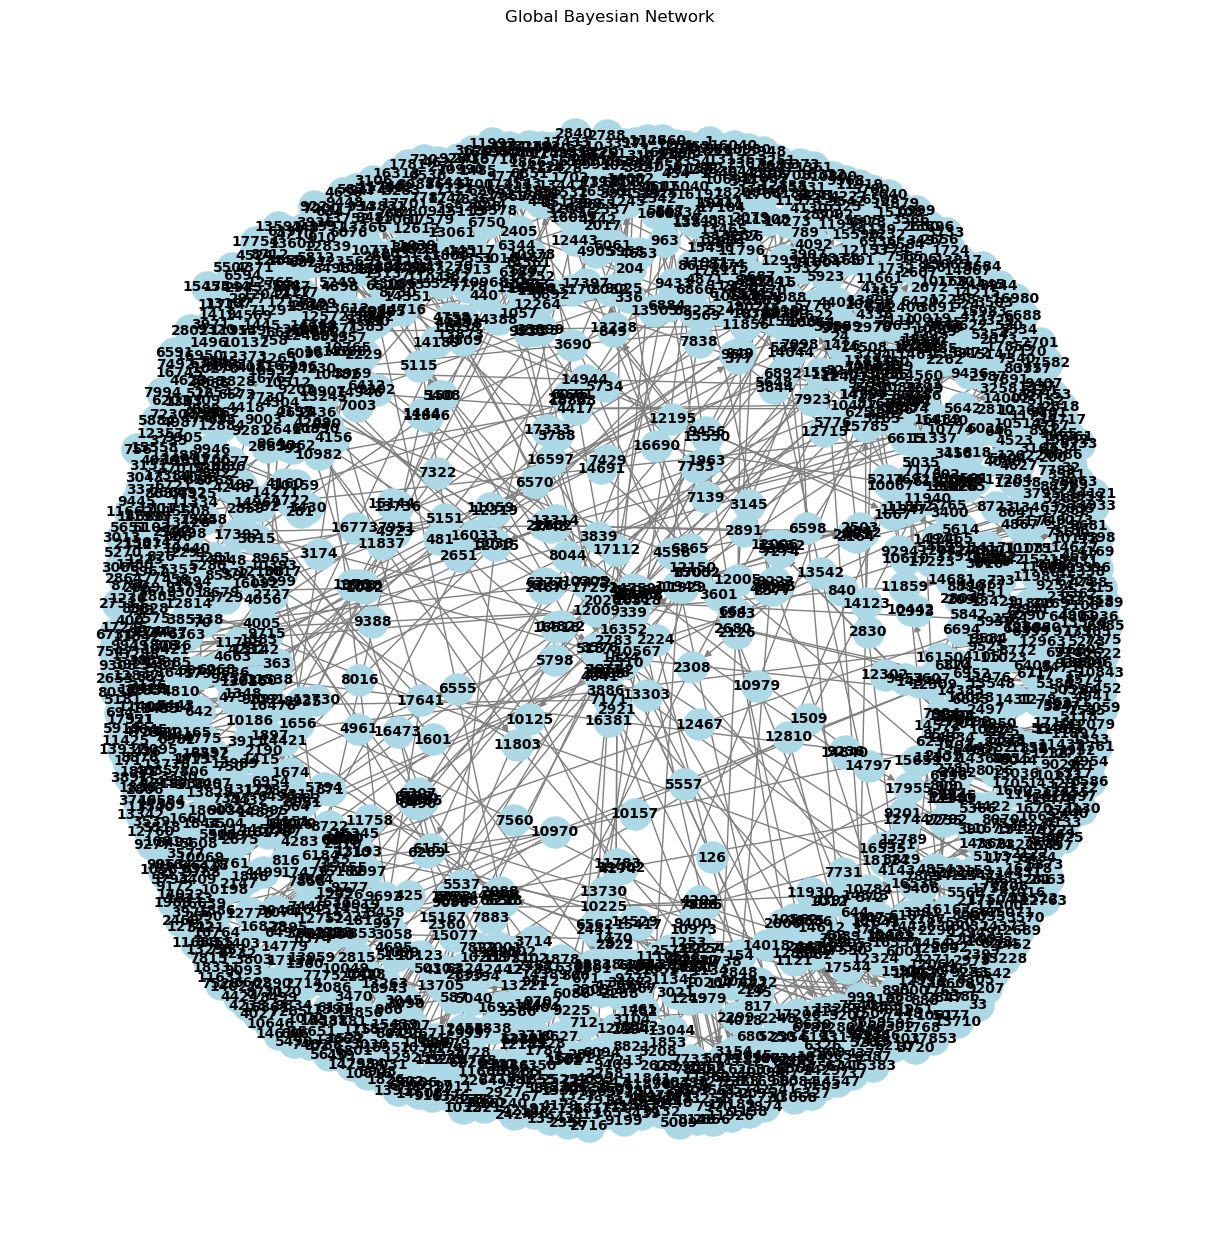

Network Analysis:
Number of nodes: 1928
Number of edges: 1487

Top 5 nodes by in-degree:
[(3835, 18), (7765, 15), (6184, 10), (10438, 8), (4092, 8)]

Top 5 nodes by out-degree:
[(6190, 9), (3578, 6), (16195, 6), (17641, 6), (4538, 6)]


In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def plot_network_and_analyze_topology(global_bn_model):
    # 将贝叶斯网络转换为 networkx 图形
    nx_graph = nx.DiGraph(global_bn_model_hc.edges())

    # 绘制网络
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(nx_graph)  # 使用spring布局进行节点位置的计算
    nx.draw(nx_graph, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
    plt.title("Global Bayesian Network")
    plt.show()

    # 网络分析
    print("Network Analysis:")
    print(f"Number of nodes: {nx_graph.number_of_nodes()}")
    print(f"Number of edges: {nx_graph.number_of_edges()}")

    # 计算入度和出度
    in_degrees = nx_graph.in_degree()
    out_degrees = nx_graph.out_degree()

    print("\nTop 5 nodes by in-degree:")
    print(sorted(in_degrees, key=lambda x: x[1], reverse=True)[:5])

    print("\nTop 5 nodes by out-degree:")
    print(sorted(out_degrees, key=lambda x: x[1], reverse=True)[:5])

plot_network_and_analyze_topology(global_bn_model_hc)

In [12]:
def compute_markov_blanket(global_bn_model, node):
    """
    计算指定节点的 Markov Blanket。
    """
    markov_blanket = global_bn_model.get_markov_blanket(node)
    print(f"Markov Blanket of {node}: {markov_blanket}")
    return markov_blanket

def test_conditional_independence(global_bn_model, node1, node2, evidence=[]):
    """
    测试两个节点在给定证据下是否条件独立。
    """
    is_independent = global_bn_model.is_active_trail(node1, node2, evidence=evidence)
    independence_status = "independent" if not is_independent else "dependent"
    print(f"{node1} and {node2} are {independence_status} given evidence {evidence}.")
    return is_independent

def compute_directed_path_length(global_bn_model, source, target):
    """
    计算从 source 节点到 target 节点的有向最短路径长度。
    """
    nx_graph = nx.DiGraph(global_bn_model.edges())
    try:
        path_length = nx.shortest_path_length(nx_graph, source=source, target=target)
        print(f"Shortest directed path length from {source} to {target}: {path_length}")
        return path_length
    except nx.NetworkXNoPath:
        print(f"No directed path from {source} to {target}.")
        return None

def analyze_network_layers(global_bn_model):
    """
    分析贝叶斯网络的层级结构，找出每一层的节点。
    """
    nx_graph = nx.DiGraph(global_bn_model.edges())
    layers = list(nx.topological_generations(nx_graph))
    for i, layer in enumerate(layers):
        print(f"Layer {i}: {layer}")
    return layers

def analyze_connected_components(global_bn_model):
    """
    分析贝叶斯网络中的连通分量，找出最大的连通分量。
    """
    nx_graph = nx.DiGraph(global_bn_model.edges())
    components = list(nx.weakly_connected_components(nx_graph))
    largest_component = max(components, key=len)
    # print(f"Number of weakly connected components: {len(components)}")
    # print(f"Largest component size: {len(largest_component)}")
    return largest_component

def detect_functional_modules(global_bn_model):
    """
    通过社团发现算法检测功能模块。
    """
    nx_graph = nx.Graph(global_bn_model.edges())  # 转换为无向图
    communities = nx.algorithms.community.greedy_modularity_communities(nx_graph)
    # print(f"Detected {len(communities)} functional modules.")
    # for i, community in enumerate(communities):
        # print(f"Module {i+1}: {sorted(community)}")
    return communities

In [32]:
# 分析网络的层级结构
#analyze_network_layers(global_bn_model)
#连通分量
connected_components_hc = analyze_connected_components(global_bn_model_hc)
# 功能模块
functional_modules_hc = detect_functional_modules(global_bn_model_hc)

In [14]:
# standardize基因名
index_map['gene_name'] = index_map['gene_name'].fillna('').astype(str)
def standardize_gene_name(name):
    return name.strip().upper()

gene_to_node = {standardize_gene_name(gene): node for gene, node in zip(index_map['gene_name'], index_map['node'])}
print("Gene to node ID mapping created. Example mappings:", list(gene_to_node.items())[:5])
standardized_gene_names_dis = uc_dis.columns.map(lambda x: standardize_gene_name(str(x)))
print("Dis Standardized gene names:", standardized_gene_names_dis[:5])

# 检查基因名
missing_genes_dis = standardized_gene_names_dis[~standardized_gene_names_dis.isin(gene_to_node)]
print(f"Number of discrete genes missing from index map: {len(missing_genes_dis)}")
if not missing_genes.empty:
    print("Example missing genes:", missing_genes[:10])

# 基因名-节点ID-map
mapped_node_ids_dis = standardized_gene_names_dis.map(gene_to_node.get)
print("Mapped Node IDs (with potential NaNs):", mapped_node_ids[:5])
nan_str_columns = mapped_node_ids[mapped_node_ids.isna()]
if not nan_str_columns.empty:
    print(f"Columns with NaN values: {nan_str_columns}")
uc_dis.columns = mapped_node_ids_dis
nan_columns_dis = uc_dis.columns.isna()
print(f"Number of NaN columns before removal: {nan_columns.sum()}")
print(f"Number of NaN columns before removal: {nan_columns_dis.sum()}")

uc_dis = uc_dis.loc[:, ~nan_columns_dis]
print(f"Discrete Data columns after removing NaN columns (should be node IDs): {uc_dis.columns[:5]}")
print(f"Number of genes after dropping NaN columns: {uc_dis.shape[1]}")
print("Data example:", uc_dis.iloc[:5, :5])

Gene to node ID mapping created. Example mappings: [('ARF5', 0.0), ('CALM2', 1.0), ('ARHGEF9', 2.0), ('ERN1', 3.0), ('CDKN2A', 4.0)]
Dis Standardized gene names: Index(['A1BG', 'A1CF', 'A2ML1', 'A2M', 'A3GALT2'], dtype='object', name='0')
Number of discrete genes missing from index map: 0
Mapped Node IDs (with potential NaNs): Index([10312.0, 2084.0, 12085.0, 1851.0, 16860.0], dtype='float64', name='0')
Number of NaN columns before removal: 0
Number of NaN columns before removal: 0
Discrete Data columns after removing NaN columns (should be node IDs): Index([10312.0, 2084.0, 12085.0, 1851.0, 16860.0], dtype='float64', name='0')
Number of genes after dropping NaN columns: 16542
Data example: 0           10312.0  2084.0   12085.0  1851.0   16860.0
GSM2932827        0        0        0        4        0
GSM2932828        0        0        0        4        0
GSM2932829        0        0        0        4        0
GSM2932830        0        0        0        4        0
GSM2932831        0 

In [ ]:
# UC训练
print("Starting Bayesian network construction (single-threaded)")
max_networks_to_construct = 16542  # 调试
local_bn_models = construct_local_bayesian_networks(uc_dis, local_networks, max_networks_to_construct, search_algorithm='hill_climb', score_type='k2')
non_empty_bn_models = [model for model in local_bn_models if model is not None and len(model.edges()) > 0]
empty_bn_count = len(local_bn_models) - len(non_empty_bn_models)
output_directory = '/Users/martinli/Desktop/SZ/local_bn_models_uc'
save_local_bn_models(non_empty_bn_models, output_directory)

In [16]:
print(f"Finished Bayesian network construction")
print(f"Local Bayesian networks saved in {output_directory}")
print(f"Total networks constructed: {len(local_bn_models)}")
print(f"Non-empty networks: {len(non_empty_bn_models)}")
print(f"Empty networks (no edges): {empty_bn_count}")

Finished Bayesian network construction
Local Bayesian networks saved in /Users/martinli/Desktop/SZ/local_bn_models_uc
Total networks constructed: 16542
Non-empty networks: 366
Empty networks (no edges): 16176


In [ ]:
# 主函数
input_directory = '/Users/martinli/Desktop/SZ/local_bn_models_uc'
output_file_csv = '/Users/martinli/Desktop/SZ/global_bn_model_uc.csv'
output_file_graphml = '/Users/martinli/Desktop/SZ/global_bn_model_uc.graphml'
local_bn_models = load_local_bn_models(input_directory)

# 组合所有局部网络到一个全局网络
global_bn_model_uc = combine_local_networks(local_bn_models)
save_global_bn_model(global_bn_model_uc, output_file_graphml, output_file_csv)

print("Finished combining local networks into a global Bayesian Network.")

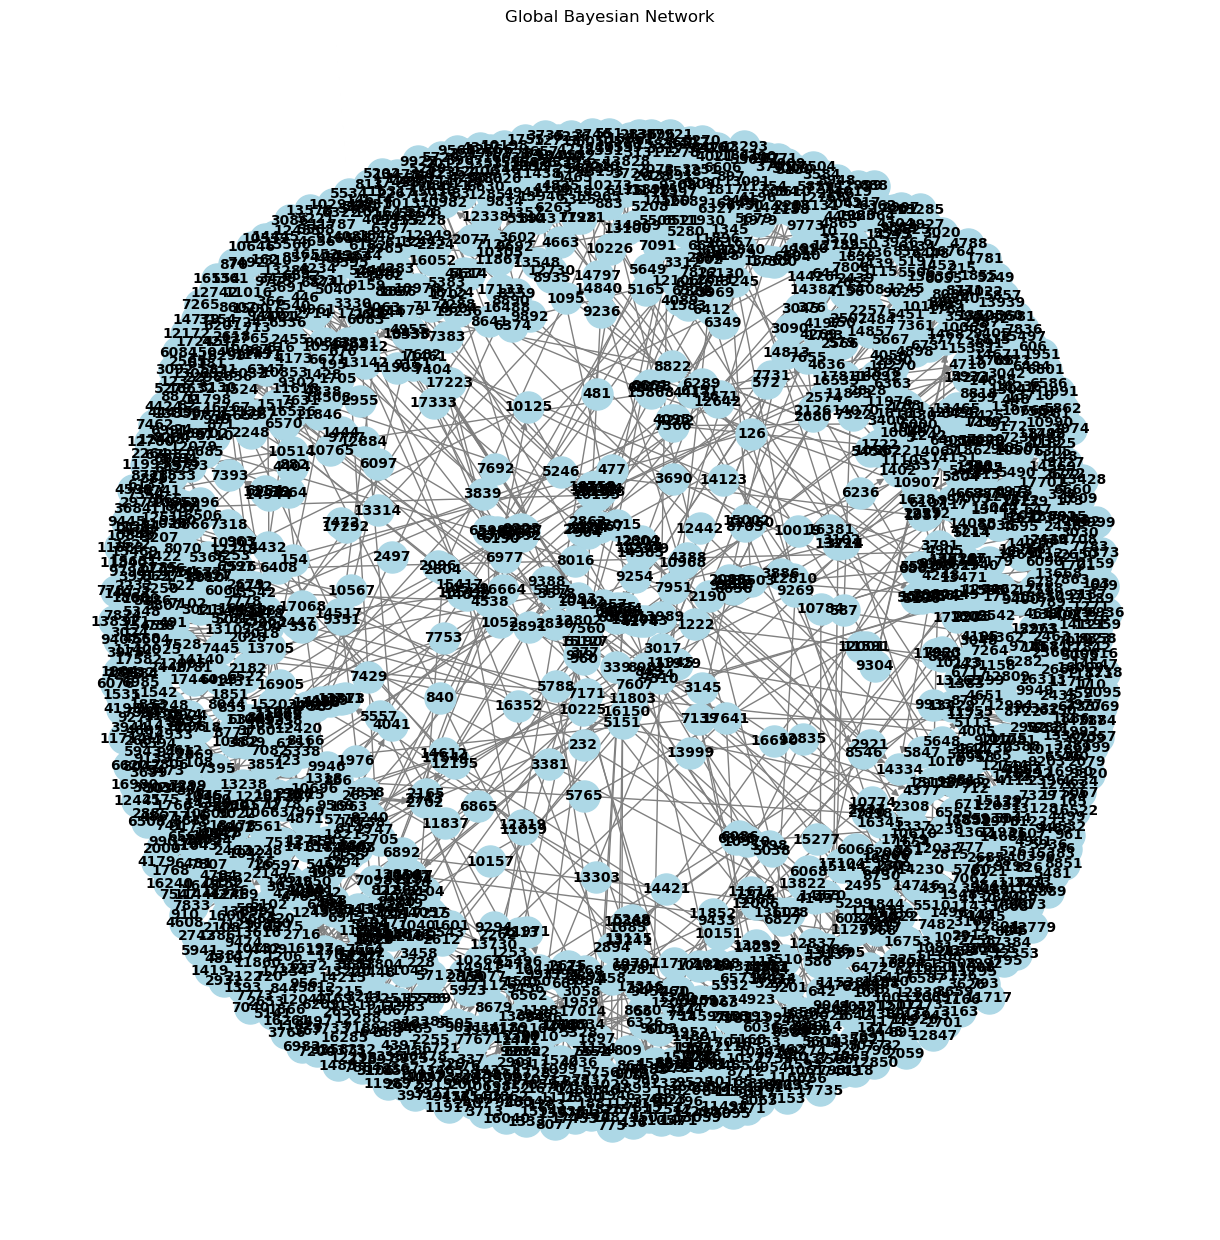

Network Analysis:
Number of nodes: 1928
Number of edges: 1487

Top 5 nodes by in-degree:
[(3835, 18), (7765, 15), (6184, 10), (10438, 8), (4092, 8)]

Top 5 nodes by out-degree:
[(6190, 9), (3578, 6), (16195, 6), (17641, 6), (4538, 6)]


In [18]:
plot_network_and_analyze_topology(global_bn_model_uc)

In [19]:
# 分析网络的层级结构
#analyze_network_layers(global_bn_model)
#连通分量
connected_components_uc = analyze_connected_components(global_bn_model_uc)
# 功能模块
functional_modules_uc = detect_functional_modules(global_bn_model_uc)

In [20]:
import networkx as nx
import pandas as pd
import os

def extract_and_save_connected_components(global_bn_model, output_dir):
    """
    提取全局网络中的所有独立通路（弱连通分量），并将每个子网保存为单独的文件。
    
    参数：
    - global_bn_model: 全局贝叶斯网络（pgmpy.models.BayesianNetwork 对象）
    - output_dir: 保存子网的目录
    """
    # 确保输出目录存在
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 将贝叶斯网络转换为 networkx 图形
    nx_graph = nx.DiGraph(global_bn_model.edges())
    
    # 识别所有弱连通分量
    weakly_connected_components = list(nx.weakly_connected_components(nx_graph))
    
    print(f"Number of weakly connected components: {len(weakly_connected_components)}")
    
    # 遍历每个连通分量，提取子网并保存
    for i, component in enumerate(weakly_connected_components):
        # 提取子网
        subgraph = nx_graph.subgraph(component).copy()
        
        # 将子网的边保存为 CSV 文件
        edges = list(subgraph.edges())
        edges_df = pd.DataFrame(edges, columns=['Source', 'Target'])
        edges_df.to_csv(os.path.join(output_dir, f'component_{i+1}.csv'), index=False)
        
        print(f"Saved component {i+1} with {len(edges)} edges and {len(component)} nodes.")

In [ ]:
output_directory = '/Users/martinli/Desktop/SZ/hc_comp'
extract_and_save_connected_components(global_bn_model_hc, output_directory)

In [ ]:
output_directory = '/Users/martinli/Desktop/SZ/uc_comp'
extract_and_save_connected_components(global_bn_model_uc, output_directory)

In [ ]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork

def load_bn_from_edges_file(file_path):
    """
    从 CSV 文件加载贝叶斯网络的边，并返回对应的 BayesianNetwork 对象。
    """
    edges_df = pd.read_csv(file_path)
    edges = [tuple(x) for x in edges_df.values]
    bn_model = BayesianNetwork(edges)
    return bn_model

def plot_bayesian_network(bn_model, title='Bayesian Network', layout='spring'):
    """
    绘制贝叶斯网络。
    """
    try:
        plt.figure(figsize=(10, 8))
        if layout == 'spring':
            pos = nx.spring_layout(bn_model)
        elif layout == 'circular':
            pos = nx.circular_layout(bn_model)
        else:
            pos = nx.spring_layout(bn_model)  # 默认使用 spring 布局
        
        nx.draw(bn_model, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=12, font_weight='bold', edge_color='gray')
        plt.title(title)
        plt.show()
    except KeyboardInterrupt:
        print("Plotting interrupted by user.")
    except Exception as e:
        print(f"Error plotting {title}: {e}")

output_directory = '/Users/martinli/Desktop/SZ/hc_comp'  
for idx, filename in enumerate(os.listdir(output_directory)):
    file_path = os.path.join(output_directory, filename)
    if filename.endswith('.csv'):
        bn_model = load_bn_from_edges_file(file_path)
        if bn_model is not None and len(bn_model.edges()) > 1:  # 仅绘制包含多于一条边的网络
            plot_bayesian_network(bn_model, title=f'Local Bayesian Network {idx + 1}', layout='circular')
        else:
            pass
            # print(f'Local Bayesian Network {idx + 1} has one or no edges, skipping.')
    else:
        print(f'Skipping file {filename}, not a CSV file.')

In [ ]:
output_directory = '/Users/martinli/Desktop/SZ/uc_comp'  
for idx, filename in enumerate(os.listdir(output_directory)):
    file_path = os.path.join(output_directory, filename)
    if filename.endswith('.csv'):
        bn_model = load_bn_from_edges_file(file_path)
        if bn_model is not None and len(bn_model.edges()) > 1:  # 仅绘制包含多于一条边的网络
            plot_bayesian_network(bn_model, title=f'Local Bayesian Network {idx + 1}', layout='circular')
        else:
            # print(f'Local Bayesian Network {idx + 1} has one or no edges, skipping.')
            pass
    else:
        print(f'Skipping file {filename}, not a CSV file.')

In [36]:
import networkx as nx

def compare_global_networks(global_bn_model_uc, global_bn_model_hc):
    # 提取边和节点
    edges_uc = set(global_bn_model_uc.edges())
    edges_hc = set(global_bn_model_hc.edges())
    
    nodes_uc = set(global_bn_model_uc.nodes())
    nodes_hc = set(global_bn_model_hc.nodes())
    
    # 比较边的不同
    unique_to_uc_edges = edges_uc - edges_hc  
    unique_to_hc_edges = edges_hc - edges_uc  
    
    # 比较节点的不同
    unique_to_uc_nodes = nodes_uc - nodes_hc
    unique_to_hc_nodes = nodes_hc - nodes_uc
    
    # 输出不同的边
    print("Unique edges to global_bn_model_uc:")
    for edge in unique_to_uc_edges:
        print(edge)

    print("\nUnique edges to global_bn_model_hc:")
    for edge in unique_to_hc_edges:
        print(edge)
    
    # 输出不同的节点
    print("\nUnique nodes to global_bn_model_uc:")
    for node in unique_to_uc_nodes:
        print(node)

    print("\nUnique nodes to global_bn_model_hc:")
    for node in unique_to_hc_nodes:
        print(node)
    
    print("Unique HC edges:" , len(unique_to_hc_edges), "out of", len(edges_hc))
    print("Unique UC edges:", len(unique_to_uc_edges), "out of", len(edges_uc))
    print("Unique HC nodes:" , len(unique_to_hc_nodes), "out of", len(nodes_hc))
    print("Unique UC nodes:", len(unique_to_uc_nodes), "out of", len(nodes_uc))
compare_global_networks(global_bn_model_uc, global_bn_model_hc)

Unique edges to global_bn_model_uc:
(12442.0, 1866.0)
(14629.0, 4811.0)
(4267.0, 4478.0)
(18464.0, 8803.0)
(11966.0, 12001.0)
(4905.0, 1696.0)
(10143.0, 4271.0)
(450.0, 5574.0)
(9303.0, 14582.0)
(14154.0, 9392.0)
(629.0, 6708.0)
(1470.0, 5.0)
(5958.0, 16195.0)
(9898.0, 8604.0)
(4135.0, 12251.0)
(1881.0, 1674.0)
(1185.0, 1333.0)
(2546.0, 9792.0)
(1970.0, 2277.0)
(163.0, 1990.0)
(111.0, 2437.0)
(7892.0, 5978.0)
(7148.0, 2442.0)
(4993.0, 7937.0)
(1038.0, 2976.0)
(8867.0, 6179.0)
(9141.0, 8374.0)
(2051.0, 6673.0)
(5557.0, 12890.0)
(1824.0, 16344.0)
(15090.0, 9054.0)
(2078.0, 14768.0)
(2148.0, 2440.0)
(13989.0, 936.0)
(8417.0, 5197.0)
(5889.0, 10330.0)
(7429.0, 9343.0)
(11920.0, 11080.0)
(11410.0, 5874.0)
(4325.0, 8718.0)
(17383.0, 12919.0)
(12416.0, 7726.0)
(13731.0, 14677.0)
(4242.0, 11429.0)
(16767.0, 15167.0)
(7044.0, 6648.0)
(7171.0, 14825.0)
(888.0, 2901.0)
(4798.0, 6170.0)
(7265.0, 10853.0)
(14175.0, 6925.0)
(669.0, 1285.0)
(18286.0, 12319.0)
(2521.0, 9344.0)
(4788.0, 5451.0)
(17420.

In [26]:
from pgmpy.estimators import BayesianEstimator
def learn_parameters_for_global_bn(data, bn_model):
    """
    为全局贝叶斯网络学习参数。

    参数:
    - data: pd.DataFrame，包含学习参数的数据。
    - bn_model: pgmpy.models.BayesianNetwork 对象，表示贝叶斯网络结构。

    返回:
    - 带有学习参数的贝叶斯网络模型。
    """
    try:
        data.columns = data.columns.astype(str)
        
        # 参数学习
        # print(f"开始参数学习，数据列: {data.columns.tolist()}")
        bn_model.fit(data, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)
        
        for cpd in bn_model.get_cpds():
            print(f"Learned CPD of {cpd.variable}:")
            print(cpd)
        
        return bn_model
    
    except Exception as e:
        print(f"参数学习过程中出现错误: {e}")
        raise

In [27]:
data = hc_dis.copy()
data.columns = data.columns.astype(str)
fitted_global_bn_model = learn_parameters_for_global_bn(data, global_bn_model_hc)

参数学习过程中出现错误: 4105


KeyError: 4105

In [ ]:
##暂时废弃, 尝试使用离散数据学习贝叶斯结构

'''
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, ExhaustiveSearch
from pgmpy.models import LinearGaussianBayesianNetwork
from pgmpy.factors.continuous import LinearGaussianCPD
import traceback
import os

def build_gaussian_bn_for_local_network(neighbors, data, search_algorithm='hill_climb', score_type='bic'):
    try:
        gene_ids = data.columns[neighbors]
        print(f"Neighbors: {neighbors}")
        print(f"Gene IDs: {gene_ids}")
        
        sub_data = data[gene_ids]
        print(f"Sub-data shape: {sub_data.shape}")
        print(f"Sub-data head:\n{sub_data.head()}")
        print(f"Sub-data description:\n{sub_data.describe()}")
        sub_data.columns = sub_data.columns.astype(str)
        print(f"Sub-data column types after conversion to string: {sub_data.columns.dtype}")
        
        # 检查
        if sub_data.isnull().values.any():
            print("Sub-data contains null values. Skipping this network.")
            return None
        
        if search_algorithm == 'hill_climb':
            search = HillClimbSearch(sub_data)
            if score_type == 'bic':
                scoring_method = BicScore(sub_data)
            elif score_type == 'k2':
                scoring_method = K2Score(sub_data)
            else:
                raise ValueError(f"Unsupported score type: {score_type}")
            best_model = search.estimate(scoring_method=scoring_method)
        
        elif search_algorithm == 'exhaustive':
            search = ExhaustiveSearch(sub_data)
            best_model = search.estimate()
        
        else:
            raise ValueError(f"Unsupported search algorithm: {search_algorithm}")

        print(f"Best model edges: {best_model.edges()}")

        # 转换为线性高斯贝叶斯网络模型
        gaussian_model = LinearGaussianBayesianNetwork(best_model.edges())
        
        # 为每个节点添加线性高斯CPD
        for node in gaussian_model.nodes():
            # 假设没有父节点
            mean = sub_data[node].mean()
            print("mean",mean)
            variance = sub_data[node].var()
            print("var",variance)
            cpd = LinearGaussianCPD(node, [mean], variance)
            cpd.variables = [*cpd.evidence, cpd.variable]  # 临时解决方案
            gaussian_model.add_cpds(cpd)
        
        return gaussian_model
    except Exception as e:
        print(f"Error in building network for neighbors {neighbors}: {e}")
        print(traceback.format_exc())
        return None
'''

In [ ]:
'''
def construct_local_gaussian_bayesian_networks(data, local_networks, max_networks, search_algorithm='hill_climb', score_type='bic'):
    results = []
    for i, neighbors in enumerate(local_networks[:max_networks]):
        print(f"Constructing network for local network {i+1}/{max_networks}")
        result = build_gaussian_bn_for_local_network(neighbors, data, search_algorithm, score_type)
        if result is not None:
            results.append(result)
        else:
            print(f"Failed to construct network for local network {i+1}")
    print(f"Constructed {len(results)} local Gaussian Bayesian networks.")
    return results

def save_local_gaussian_bn_models(local_bn_models, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for idx, bn_model in enumerate(local_bn_models):
        if bn_model is not None:
            edges = list(bn_model.edges())
            edges_df = pd.DataFrame(edges, columns=['Source', 'Target'])
            edges_df.to_csv(os.path.join(output_dir, f'local_gaussian_bn_model_{idx}.csv'), index=False)
            print(f"Saved local Gaussian BN model {idx} with {len(edges)} edges.")

# 主函数
print("Starting Gaussian Bayesian network construction (single-threaded)")
max_networks_to_construct = 16542  # 调试
local_gaussian_bn_models = construct_local_gaussian_bayesian_networks(hc_con, local_networks, max_networks_to_construct, search_algorithm='exhaustive')
print("Finished Gaussian Bayesian network construction")
output_directory = '/Users/martinli/Desktop/SZ/local_gaussian_bn_models'
save_local_gaussian_bn_models(local_gaussian_bn_models, output_directory)
print(f"Local Gaussian Bayesian networks saved in {output_directory}")
'''

In [ ]:
'''
# 抽样检查局部网络的结构和CPD参数
import random

# 随机抽取n个局部贝叶斯网络进行检查
def sample_and_check_local_networks(local_bn_models, num_samples=5):
    sampled_indices = random.sample(range(len(local_bn_models)), num_samples)
    for idx in sampled_indices:
        bn_model = local_bn_models[idx]
        if bn_model is not None:
            print(f"\nSampled Local Bayesian Network {idx}:")
            print("Edges:")
            print(bn_model.edges())
            print("CPDs:")
            for cpd in bn_model.get_cpds():
                print(f"\nCPD of {cpd.variable}:")
                print(cpd)
        else:
            print(f"\nSampled Local Bayesian Network {idx} is None")

# 示例调用
sample_and_check_local_networks(local_gaussian_bn_models)
'''

In [28]:
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
import pandas as pd

# 对局部贝叶斯网络进行参数学习（使用 MAP）
def learn_parameters_with_map(data, bn_model):
    model = BayesianNetwork(bn_model.edges())
    
    # 确保数据中包含所有节点
    data.columns = data.columns.astype(int).astype(str)
    missing_columns = set(model.nodes()) - set(data.columns)
    if missing_columns:
        raise ValueError(f"Data is missing columns: {missing_columns}")
    
    # 进行参数学习
    print(f"Fitting model with data columns: {data.columns.tolist()}")
    model.fit(data, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)
    
    # 打印学习到的 CPDs
    for cpd in model.get_cpds():
        print(f"Learned CPD of {cpd.variable}:")
        print(cpd)
    
    return model

# 可视化包含参数的贝叶斯网络
def plot_bayesian_network_with_params(bn_model, title='Bayesian Network'):
    try:
        # 创建一个NetworkX图形
        nx_graph = nx.DiGraph()

        # 添加节点和边到NetworkX图形中
        nx_graph.add_nodes_from(bn_model.nodes())
        nx_graph.add_edges_from(bn_model.edges())

        plt.figure(figsize=(10, 8))
        pos = nx.spring_layout(nx_graph)
        nx.draw(nx_graph, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=12, font_weight='bold')

        plt.title(title)
        plt.show()

    except Exception as e:
        print(f"Error plotting {title}: {e}")
        import traceback
        traceback.print_exc()

max_networks_to_process = 16542
for idx, bn_model in enumerate(local_bn_models[:max_networks_to_process]):
    if bn_model is not None and len(bn_model.edges()) > 0:
        print(f"Learning parameters for Local Bayesian Network {idx}")
        gene_ids = hc_dis.columns[local_networks[idx]]
        sub_data = hc_dis[gene_ids]
        sub_data.columns = sub_data.columns.astype(str).str.split('.').str[0]  # 去除小数部分
        
        print(f"Sub data columns for network {idx}: {sub_data.columns.tolist()}")
        
        try:
            learned_model = learn_parameters_with_map(sub_data, bn_model)
            
            # 输出 learned_model 的结构和参数
            print(f"Learned model structure for Local Bayesian Network {idx}:")
            print(learned_model.edges())
            for cpd in learned_model.get_cpds():
                print(f"CPD of {cpd.variable}:\n{cpd}")
            
            plot_bayesian_network_with_params(learned_model, title=f'Local Bayesian Network {idx} with Parameters')
        except ValueError as ve:
            print(f"Skipping Local Bayesian Network {idx} due to error: {ve}")
    else:
        print(f'Local Bayesian Network {idx} has no edges or is None')

Learning parameters for Local Bayesian Network 0
Sub data columns for network 0: ['10312', '17453', '14338']
Skipping Local Bayesian Network 0 due to error: Data is missing columns: {1881.0, 1674.0, 1897.0}
Learning parameters for Local Bayesian Network 1
Sub data columns for network 1: ['2084', '15251', '2162']
Skipping Local Bayesian Network 1 due to error: Data is missing columns: {11539.0, 11084.0}
Learning parameters for Local Bayesian Network 2
Sub data columns for network 2: ['12085', '18201', '2190']
Skipping Local Bayesian Network 2 due to error: Data is missing columns: {9003.0, 12542.0}
Learning parameters for Local Bayesian Network 3
Sub data columns for network 3: ['1851', '9658', '4171']
Skipping Local Bayesian Network 3 due to error: Data is missing columns: {4810.0, 10350.0}
Learning parameters for Local Bayesian Network 4
Sub data columns for network 4: ['16860', '15292', '14651']
Skipping Local Bayesian Network 4 due to error: Data is missing columns: {6792.0, 6209.0}

Sub data columns for network 774: ['12918', '14067', '16735']
Skipping Local Bayesian Network 774 due to error: Data is missing columns: {11345.0, 3021.0, 9807.0}
Learning parameters for Local Bayesian Network 775
Sub data columns for network 775: ['17054', '15292', '16195']
Skipping Local Bayesian Network 775 due to error: Data is missing columns: {12003.0, 11060.0, 14699.0}
Learning parameters for Local Bayesian Network 776
Sub data columns for network 776: ['9649', '3710', '8724']
Skipping Local Bayesian Network 776 due to error: Data is missing columns: {4484.0, 3844.0}
Learning parameters for Local Bayesian Network 777
Sub data columns for network 777: ['10297', '13024', '10965']
Skipping Local Bayesian Network 777 due to error: Data is missing columns: {14344.0, 14385.0, 8574.0}
Learning parameters for Local Bayesian Network 778
Sub data columns for network 778: ['13898', '13896', '13905']
Skipping Local Bayesian Network 778 due to error: Data is missing columns: {12338.0, 11867.

Sub data columns for network 1738: ['10761', '12858', '12867']
Skipping Local Bayesian Network 1738 due to error: Data is missing columns: {10601.0, 13193.0}
Learning parameters for Local Bayesian Network 1739
Sub data columns for network 1739: ['12861', '3992', '14494']
Skipping Local Bayesian Network 1739 due to error: Data is missing columns: {9118.0, 16195.0, 2190.0}
Learning parameters for Local Bayesian Network 1740
Sub data columns for network 1740: ['14993', '12271', '16037']
Skipping Local Bayesian Network 1740 due to error: Data is missing columns: {6184.0, 17420.0}
Learning parameters for Local Bayesian Network 1741
Sub data columns for network 1741: ['11141', '11781', '17528']
Skipping Local Bayesian Network 1741 due to error: Data is missing columns: {11404.0, 14828.0}
Learning parameters for Local Bayesian Network 1742
Sub data columns for network 1742: ['11781', '11408', '10867']
Skipping Local Bayesian Network 1742 due to error: Data is missing columns: {888.0, 2901.0, 

Sub data columns for network 2727: ['6092', '6354', '6192']
Skipping Local Bayesian Network 2727 due to error: Data is missing columns: {4195.0, 1853.0}
Learning parameters for Local Bayesian Network 2728
Sub data columns for network 2728: ['6192', '6092', '6354']
Skipping Local Bayesian Network 2728 due to error: Data is missing columns: {6025.0, 3269.0}
Learning parameters for Local Bayesian Network 2729
Sub data columns for network 2729: ['6683', '15906', '16927']
Skipping Local Bayesian Network 2729 due to error: Data is missing columns: {11048.0, 11058.0}
Learning parameters for Local Bayesian Network 2730
Sub data columns for network 2730: ['6354', '6092', '6192']
Skipping Local Bayesian Network 2730 due to error: Data is missing columns: {1081.0, 1844.0, 6455.0}
Learning parameters for Local Bayesian Network 2731
Sub data columns for network 2731: ['5715', '4998', '5150']
Skipping Local Bayesian Network 2731 due to error: Data is missing columns: {8240.0, 8542.0}
Learning parame

Adding Local Bayesian Network 0 to Global Network
Adding Local Bayesian Network 1 to Global Network
Adding Local Bayesian Network 2 to Global Network
Adding Local Bayesian Network 3 to Global Network
Adding Local Bayesian Network 4 to Global Network
Adding Local Bayesian Network 5 to Global Network
Adding Local Bayesian Network 6 to Global Network
Adding Local Bayesian Network 7 to Global Network
Adding Local Bayesian Network 8 to Global Network
Adding Local Bayesian Network 9 to Global Network
Adding Local Bayesian Network 10 to Global Network
Adding Local Bayesian Network 11 to Global Network
Adding Local Bayesian Network 12 to Global Network
Adding Local Bayesian Network 13 to Global Network
Adding Local Bayesian Network 14 to Global Network
Adding Local Bayesian Network 15 to Global Network
Adding Local Bayesian Network 16 to Global Network
Adding Local Bayesian Network 17 to Global Network
Adding Local Bayesian Network 18 to Global Network
Adding Local Bayesian Network 19 to Globa

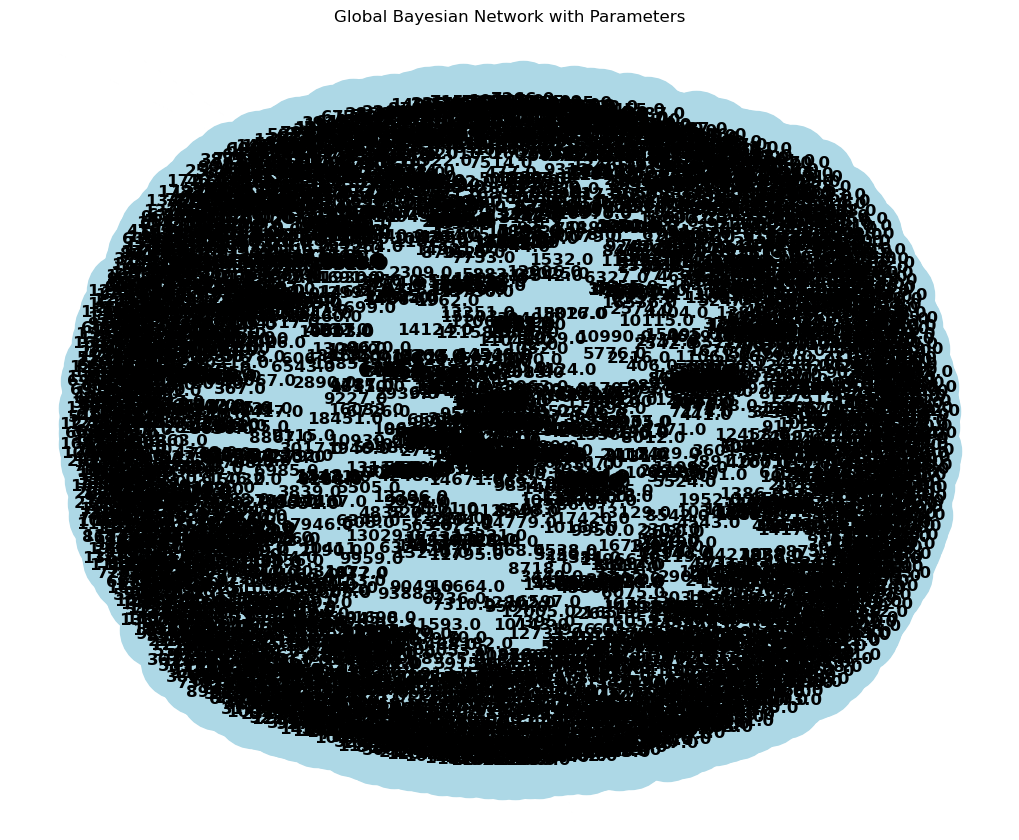

In [29]:
from pgmpy.models import BayesianNetwork
global_bn_model = BayesianNetwork()
def add_local_network_to_global(global_model, local_model):
    global_model.add_nodes_from(local_model.nodes())
    global_model.add_edges_from(local_model.edges())
    for cpd in local_model.get_cpds():
        global_model.add_cpds(cpd)
for idx in range(len(local_bn_models[:16542])):
    if local_bn_models[idx] is not None and len(local_bn_models[idx].edges()) > 0:
        print(f"Adding Local Bayesian Network {idx} to Global Network")
        try:
            add_local_network_to_global(global_bn_model, local_bn_models[idx])
        except Exception as e:
            print(f"Error adding Local Bayesian Network {idx}: {e}")

# 输出全局贝叶斯网络的结构和参数
print("Global Bayesian Network structure:")
print(global_bn_model.edges())
for cpd in global_bn_model.get_cpds():
    print(f"CPD of {cpd.variable}:\n{cpd}")

# 可视化全局贝叶斯网络
plot_bayesian_network_with_params(global_bn_model, title='Global Bayesian Network with Parameters')